In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import json
import contextily as ctx
import warnings
warnings.filterwarnings("ignore")

In [2]:
def read_grid_geojson(filename):    
    with open(filename, 'r') as file:
        grid_dict = json.load(file)
        return grid_dict

def extract_grid_gdf(filename):
    grid_dict = read_grid_geojson(filename)
    grid = gpd.GeoDataFrame.from_features(grid_dict['GEOGRID']['features'])
    grid.set_crs('EPSG:4326', inplace=True)
    return grid

def extract_types_gdf(filename):
    grid_dict = read_grid_geojson(filename)
    types = pd.DataFrame.from_dict(grid_dict['GEOGRID']['properties']['types']).transpose()
    return types

grid_filename = '/app/data/grid_testing.geojson'

grid = extract_grid_gdf(grid_filename)
types = extract_types_gdf(grid_filename)

grid.to_parquet('/app/data/cityscope_grid.parquet')

NameError: name 'json' is not defined

In [3]:
# Función para convertir de [R, G, B] a formato hexadecimal
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*rgb)

# Crear una nueva columna con los colores en formato hexadecimal
grid['color_hex'] = grid['color'].apply(rgb_to_hex)

In [4]:
from shapely.geometry import Polygon

def create_bounding_polygon(gdf):
    # Obtener todos los puntos de los polígonos en el GeoDataFrame
    points = gdf.geometry.apply(lambda poly: poly.exterior.coords if poly.type == 'Polygon' else [p for poly in poly.geoms for p in poly.exterior.coords])
    points = [point for sublist in points for point in sublist]

    # Encontrar los puntos extremos
    min_lon_point = min(points, key=lambda p: p[0])
    max_lat_point = max(points, key=lambda p: p[1])
    max_lon_point = max(points, key=lambda p: p[0])
    min_lat_point = min(points, key=lambda p: p[1])

    # Crear el polígono con los puntos extremos
    bounding_polygon = Polygon([
        (min_lon_point[0], min_lon_point[1]),
        (max_lat_point[0], max_lat_point[1]),
        (max_lon_point[0], max_lon_point[1]),
        (min_lat_point[0], min_lat_point[1])
    ])

    return bounding_polygon

In [5]:
bounding_polygon = create_bounding_polygon(grid)
bounding_gdf = gpd.GeoDataFrame(geometry=[bounding_polygon])
bounding_gdf.set_crs('EPSG:4326', inplace=True)
pass

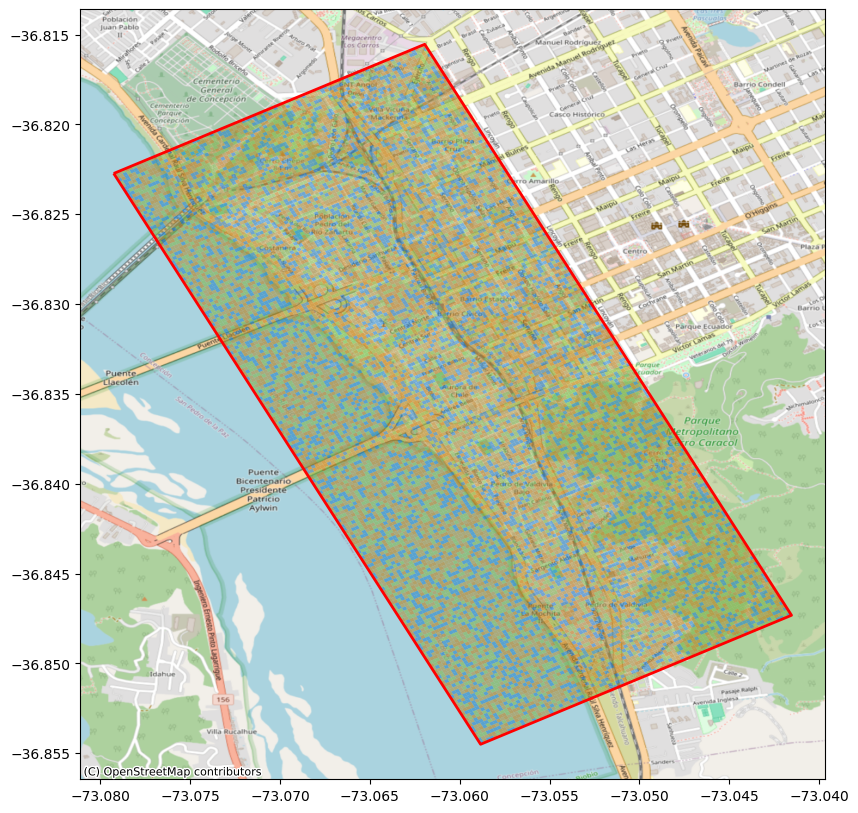

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

grid.plot(
    ax=ax,
    color=grid['color_hex'],
    alpha=0.6,
    markersize=100,
    )

bounding_gdf.boundary.plot(
    ax=ax,
    edgecolor='red',
    linewidth=2,
    )

ctx.add_basemap(
    ax,
    crs=grid.crs,
    source=ctx.providers.OpenStreetMap.Mapnik,
    )

plt.show()

## Tratamiento para las amenities

In [7]:
amenities = gpd.read_parquet('/app/assets/amenities/actual.parquet')
amenities.set_crs('EPSG:4326', inplace=True)
pass

In [8]:
amenities_filtered = gpd.overlay(amenities, bounding_gdf)
pass

In [9]:
amenities_filtered = gpd.sjoin(grid, amenities_filtered)

In [10]:
amenities_per_category_in_grid = pd.DataFrame(amenities_filtered.value_counts(subset=['category', 'id'])).reset_index()
amenities_per_category_in_grid.rename(columns={0: 'count'}, inplace=True)

In [11]:
amenities_total_in_grid = pd.DataFrame(amenities_filtered.value_counts(subset=['id'])).reset_index()
amenities_total_in_grid.rename(columns={0: 'count'}, inplace=True)

In [12]:
amenities_per_category_in_grid_with_total = pd.merge(amenities_per_category_in_grid, amenities_total_in_grid, on=['id'], suffixes=['_cat', '_total'])

In [13]:
amenities_per_category_in_grid_with_total['portion'] = amenities_per_category_in_grid_with_total['count_cat']/amenities_per_category_in_grid_with_total['count_total']

In [14]:
category_on_grid_with_total = amenities_per_category_in_grid_with_total.groupby('id').agg(
    n_cat=('category', 'nunique'),
    count_total=('count_total', 'first')
).reset_index()

<Axes: xlabel='count_total', ylabel='n_cat'>

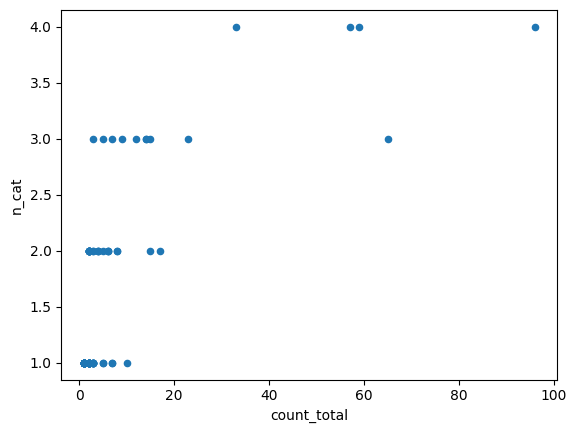

In [16]:
category_on_grid_with_total.plot(kind='scatter', x='count_total', y='n_cat')

## Tratamiento de las edificaciones

In [17]:
buildings = gpd.read_parquet('/app/assets/buildings/actual.parquet')
buildings.to_crs(4326, inplace=True)
pass

In [18]:
buildings_on_grid = gpd.overlay(grid, buildings)
buildings_on_grid = buildings_on_grid[['id', 'Pisos', 'Metros', 'geometry']]

In [19]:
max_values_by_grid = buildings_on_grid.groupby('id').agg({
    'Pisos': 'max',
    'Metros': 'max',
}).reset_index()

In [20]:
import numpy as np
buildings_on_grid['log(Metros)'] = np.log10(buildings_on_grid['Metros'])
buildings_on_grid['log_n(Metros)'] = buildings_on_grid['log(Metros)']/buildings_on_grid['log(Metros)'].max()

buildings_on_grid['Metros_n'] = buildings_on_grid['Metros']/buildings_on_grid['Metros'].max()

In [21]:
# Agrupar por 'id' y obtener el valor máximo de 'Pisos' y 'Metros'
buildings_on_grid_max = buildings_on_grid.groupby('id').agg({'Pisos': 'max', 'Metros': 'max'}).reset_index()

buildings_out = grid.merge(buildings_on_grid_max[['id', 'Pisos', 'Metros']], on='id', how='left')
buildings_out.fillna(0, inplace=True)

import math
# Actualizar la columna 'height' basándose en la columna 'Metros' y redondeando al entero superior
buildings_out['height'] = buildings_out['Metros'].apply(lambda x: [0, math.ceil(x), math.ceil(2 * x)])

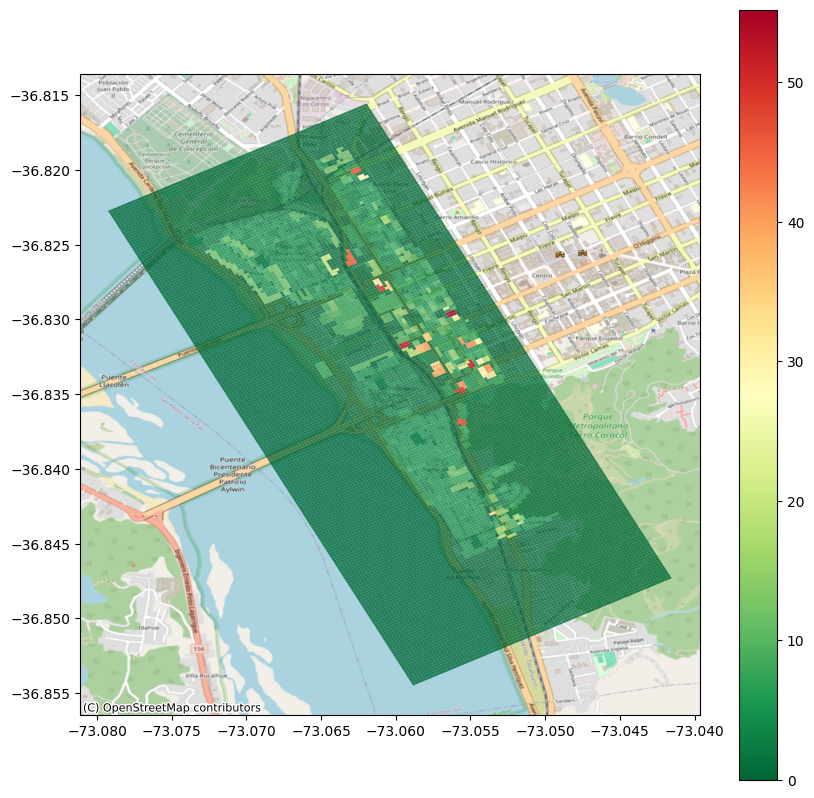

In [23]:
# Crear el plot
fig, ax = plt.subplots(figsize=(10, 10))

plot_col = 'Metros'

# Plotear el GeoDataFrame usando la columna 'value_column' para la escala de colores
buildings_out.plot(
    column=plot_col,
    cmap='RdYlGn_r',
    legend=True,
    ax=ax,
    alpha=0.8,
)

# Agregar un mapa de fondo si es necesario
ctx.add_basemap(
    ax,
    crs=buildings_out.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik,
)

# Mostrar el plot
plt.show()

## Tratamiento usos de suelo

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

class LandUseAnalysis:
    def __init__(self):
        # Inicialización y carga de datos
        self.landuses = self.read_data('/app/data/land_uses_clean.parquet')
        # self.grid = self.read_data('/app/data/cityscope_grid.parquet')
        self.grid = self.load_grid('/app/data/input/grid_cityscope.parquet')
        self.landuses_on_grid = None
        self.landuses_areas_agg_on_grid = None
        self.count_landuse_on_grid = None

        # Configuración inicial de los colores
        self.color_dict = {
            'SITIO ERIAZO': '#E57373',
            'HABITACIONAL': '#81C784',
            'EDUCACION Y CULTURA': '#64B5F6',
            'BODEGA Y ALMACENAJE': '#F06292',
            'BIENES COMUNES': '#DCE775',
            'OTROS': '#4DD0E1',
            'INDUSTRIA': '#BA68C8',
            'SALUD': '#FFB74D',
            'CULTO': '#9575CD',
            'OFICINA': '#AED581',
            'COMERCIO': '#F48FB1',
            'TRANSPORTE Y TELEC': '#B0BEC5',
            'AREAS VERDES': '#4CAF50',
            'DEPORTE Y RECREACION': '#7986CB',
            'HOTEL, MOTEL': '#F06292',
            'ESTACIONAMIENTO': '#00ACC1',
            'ADM PUBLICA Y DEFENSA': '#EF5350',
            'AGRICOLA': '#8BC34A',
            'S/I': '#D3D3D3'  # Color gris claro para 'S/I'
        }
        self.color_config = pd.DataFrame(list(self.color_dict.items()), columns=['Uso', 'color_hex'])
        self.color_config['color_rgb'] = self.color_config['color_hex'].apply(self.hex_to_rgb)

    def load_grid(self, filename):
        # self.grid = self.load_grid(table='costanera_conce')
        gdf = gpd.read_parquet(filename)
        gdf.set_crs(4326, inplace=True)
        return gdf

    def plot_with_contextily(self):
        # Configurar la figura y los ejes para el plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        # Convertir el CRS al sistema Web Mercator para coincidir con el mapa base de Contextily
        self.grid = self.grid.to_crs(4326)
        # Plotear el GeoDataFrame utilizando los colores hexadecimales asignados
        self.grid.plot(ax=ax, color=self.grid['color_hex'], alpha=0.7, edgecolor='none')
        # Añadir el mapa base de Contextily
        ctx.add_basemap(ax=ax, crs=self.grid.crs, source=ctx.providers.OpenStreetMap.Mapnik)
        # Ajustar los límites de la visualización
        ax.set_axis_off()
        plt.show()

    def read_data(self, file_path):
        # Método para leer datos desde un archivo Parquet
        return gpd.read_parquet(file_path)

    def clean_land_uses(self):
        # Limpieza de los usos de suelo no deseados
        delete_categories = ['MULTI ROL', 'PRE ROL']
        self.landuses = self.landuses[~self.landuses['Uso'].isin(delete_categories)]

    def spatial_overlay(self):
        # Cruce de polígonos de usos de suelo contenidos dentro de las cuadrículas de la grilla
        self.landuses_on_grid = gpd.overlay(self.grid, self.landuses, how='intersection')
        # Filtrado de columnas de interés
        self.landuses_on_grid = self.landuses_on_grid[['id', 'Uso', 'geometry']]

    def calculate_areas(self):
        # Calcular el área de cada polígono después de cambiar la proyección CRS
        self.landuses_on_grid.to_crs(32718, inplace=True)
        self.landuses_on_grid['area'] = self.landuses_on_grid.area

    def aggregate_area_by_use(self):
        # Agrupar las áreas por cuadrícula y uso de suelo, sumando las áreas
        self.landuses_areas_agg_on_grid = self.landuses_on_grid.groupby(['id', 'Uso']).agg({'area': 'sum'}).reset_index()
        
    def assign_dominant_land_use(self):
        # Asignar el uso dominante a cada cuadricula de la grilla
        dominant_land_uses = self.landuses_areas_agg_on_grid.sort_values(['id', 'area'], ascending=[True, False])
        # Eliminar duplicados manteniendo el registro con mayor área por cada id
        dominant_land_uses = dominant_land_uses.drop_duplicates(subset='id')
        # Unir con la grilla original para actualizar los usos de suelo
        self.grid = self.grid.merge(dominant_land_uses[['id', 'Uso']], on='id', how='left')

    def fill_missing_land_use(self, fill_value):
        # Método para rellenar NaN en el campo 'Uso' del DataFrame 'grid' con un valor específico
        self.grid['Uso'].fillna(fill_value, inplace=True)

    def hex_to_rgb(self, hex_color):
        hex_color = hex_color.lstrip('#')
        return list(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

    def assign_colors(self):
        # Asignar colores según el uso de suelo
        self.grid = self.grid.merge(self.color_config, on='Uso', how='left')

    def export_grid(self, filename='/app/data/landuses_grid.parquet'):
        cols = ['id', 'name', 'height', 'interactive', 'Uso', 'color_rgb', 'geometry']
        self.export_grid_gdf = self.grid[cols]
        self.export_grid_gdf.rename(columns={'color_rgb': 'color'}, inplace=True)
        self.export_grid_gdf.to_parquet(filename)

In [3]:
# Crea el objeto y carga los datos
analysis = LandUseAnalysis()
# Limpia usos de suelo
analysis.clean_land_uses()
# Hace el overlay entre landuses y grid
analysis.spatial_overlay()
# Agrega las áreas de cada landuse por cuadricula
analysis.calculate_areas()
# Agrupa las áreas de cada uso por cuadricula
analysis.aggregate_area_by_use()
# Asigna el uso de suelo dominante a cada cuadricula
analysis.assign_dominant_land_use()
# Rellenar valores faltantes en 'Uso' con un string específico
analysis.fill_missing_land_use("S/I")
# Asignar colores a cada cuadricula
analysis.assign_colors()
# Exportar en formato parquet
analysis.export_grid()

/tmp/ipykernel_4810/3862847084.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.grid['Uso'].fillna(fill_value, inplace=True)
/tmp/ipykernel_4810/3862847084.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.export_grid_gdf.rename(columns={'color_rgb': 'color'}, inplace=True)


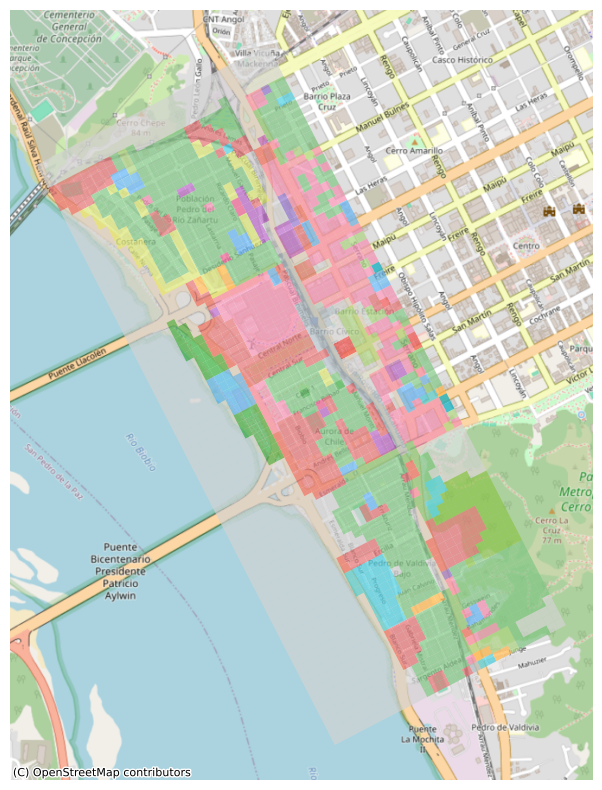

In [5]:
analysis.plot_with_contextily()

## Merging algunos cambios

In [398]:
new_grid = grid[['id', 'interactive']]

In [399]:
new_grid = pd.merge(new_grid, buildings_out[['id','height']], on=['id'])

In [400]:
new_grid = pd.merge(new_grid, landuses_on_grid_with_color[['id', 'Uso', 'color', 'color_hex']], on=['id'])
new_grid['name'] = new_grid['Uso']
del new_grid['Uso']

In [401]:
new_grid = pd.merge(new_grid, grid[['id', 'geometry']], on='id')

In [402]:
new_grid = gpd.GeoDataFrame(data=new_grid.drop(columns=['geometry']), geometry=new_grid['geometry'])

In [403]:
new_grid.to_parquet('/app/data/new_grid_cityscope.parquet')

In [407]:
new_grid.drop_duplicates(subset=['id'])

id  interactive     height            color color_hex          name  \
0       1687         True  [0, 0, 0]  [229, 115, 115]   #E57373  SITIO ERIAZO   
1       1692        False  [0, 0, 0]  [229, 115, 115]   #E57373  SITIO ERIAZO   
2       1698         True  [0, 0, 0]  [229, 115, 115]   #E57373  SITIO ERIAZO   
3       1774         True  [0, 0, 0]  [229, 115, 115]   #E57373  SITIO ERIAZO   
4       1775        False  [0, 0, 0]  [229, 115, 115]   #E57373  SITIO ERIAZO   
...      ...          ...        ...              ...       ...           ...   
13914  14742         True  [0, 0, 0]  [129, 199, 132]   #81C784  HABITACIONAL   
13918  14827         True  [0, 0, 0]  [129, 199, 132]   #81C784  HABITACIONAL   
13919  14828        False  [0, 0, 0]  [129, 199, 132]   #81C784  HABITACIONAL   
13920  14829         True  [0, 0, 0]  [129, 199, 132]   #81C784  HABITACIONAL   
13922  14830         True  [0, 0, 0]  [129, 199, 132]   #81C784  HABITACIONAL   

                                                geometry  
0      POLYGON ((-73.07438 -36.82451, -73.07428 -36.8...  
1      POLYGON ((-73.07340 -36.82410, -73.07329 -36.8...  
2      POLYGON ((-73.07222 -36.82361, -73.07211 -36.8...  
3      POLYGON ((-73.07447 -36.82475, -73.07437 -36.8...  
4      POLYGON ((-73.07428 -36.82467, -73.07418 -36.8...  
...                                                  ...  
13914  POLYGON ((-73.05325 -36.84538, -73.05315 -36.8...  
13918  POLYGON ((-73.05374 -36.84578, -73.05363 -36.8...  
13919  POLYGON ((-73.05354 -36.84570, -73.05344 -36.8...  
13920  POLYGON ((-73.05334 -36.84562, -73.05324 -36.8...  
13922  POLYGON ((-73.05315 -36.84553, -73.05304 -36.8...  

[5864 rows x 7 columns]

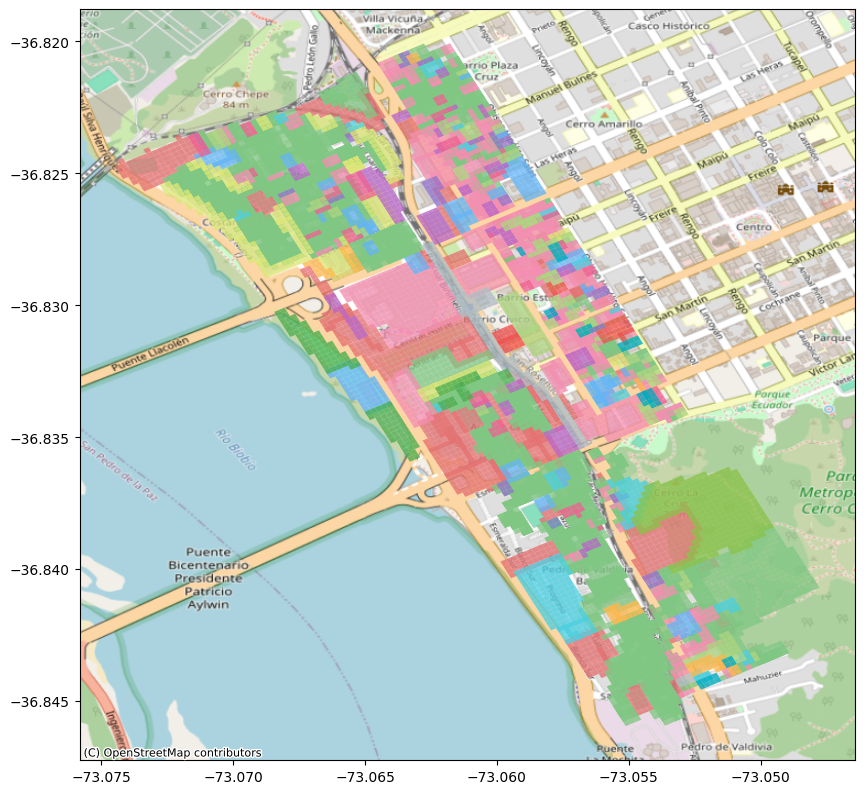

In [405]:
# Crear el plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear el GeoDataFrame usando la columna 'value_column' para la escala de colores
new_grid.plot(
    color=new_grid['color_hex'],
    legend=True,
    ax=ax,
    alpha=0.8,
)

# Agregar un mapa de fondo si es necesario
ctx.add_basemap(
    ax,
    crs=buildings_out.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik,
)

# Mostrar el plot
plt.show()